# Coding Sample for Predoc Application - Razvan Banescu

The following is a coding sample for my predoc application. It aims to provide a Two-Way Fixed Effects (TWFE) model that analyzes whether a decrease in the level of corruption (measured by the **Corruption Perception Index (CPI)** from Transparency International) has a positive impact on the effectiveness of Official Development Assistance (ODA), measured as the effect of ODA on **GDP per capita**.

## Data Sources

The data on **ODA**, **GDP**, and other macroeconomic controls are sourced from the **World Bank**:

[World Development Indicators - World Bank](https://databank.worldbank.org/source/world-development-indicators)

The data on **CPI** is sourced from **Transparency International**:

[Transparency International - CPI Score](https://prosperitydata360.worldbank.org/en/indicator/TI+CPI+Score)

## Time Frame

This analysis focuses on the period **2012 to 2022**, as **CPI** data is available starting from **2012** and the latest **ODA** data from the World Bank is available up to **2022**. However, the initial exploration includes the **full time series of ODA data** to provide a broader historical context.

## Objective
The primary purpose of this sample is to **demonstrate my coding skills**, rather than to provide a rigorously unbiased experimental design. 




### 0. Importing Packages

In [1]:
# Uncomment the line below if packages are not already installed
# %pip install matplotlib numpy pandas pycountry pycountry-convert ruptures seaborn statsmodels linearmodels scikit-learn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import pycountry_convert as pc
import ruptures as rpt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import warnings

warnings.filterwarnings("ignore")

### 1. Data Importation and Cleaning
In this section, we import and clean the datasets from **.csv** and **.xlsx** files to prepare them for analysis. We define two functions: one for cleaning the initial dataset and another for cleaning the newer dataset. The goal is to ensure that all variable names are formatted consistently, missing values are handled properly, and the data is reshaped into a suitable format for analysis.
The cleaning process involves:



In [2]:
path_wb = "world_bank_indicators.csv"
path_ti = "transparency_international_cpi.xlsx"


def clean_initial_dataset(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.replace(r"\s\[YR\d{4}\]", "", regex=True)
    df.rename(
        columns={
            "Country Name": "country_name",
            "Country Code": "country_code",
            "Series Name": "var",
        },
        inplace=True,
    )
    df.replace("..", pd.NA, inplace=True)

    df["var"] = (
        df["var"]
        .str.lower()
        .str.replace("%", "percent")
        .str.replace(" ", "_")
        .str.replace(",", "")
        .str.replace("(", "")
        .str.replace(")", "")
        .str.replace("/", "_")
        .str.replace(":", "")
        .str.replace("-", "_")
    )
    df = df.drop(columns=["Series Code"])
    df = pd.melt(
        df,
        id_vars=["country_name", "country_code", "var"],
        var_name="year",
        value_name="value",
    )

    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df = df.pivot_table(
        index=["country_name", "country_code", "year"],
        columns="var",
        values="value",
        aggfunc="first",
    ).reset_index()

    return df.dropna(
        subset=df.columns.difference(["country_name", "country_code", "year"]),
        how="all",
    )


def clean_new_dataset(filepath):
    df = pd.read_excel(filepath)
    df = df.drop(columns=["Attribute 1", "Attribute 2", "Attribute 3", "Partner"])
    df.rename(
        columns={
            "Economy ISO3": "country_code",
            "Economy Name": "country_name",
            "Indicator ID": "var",
        },
        inplace=True,
    )

    df = pd.melt(
        df,
        id_vars=["country_code", "country_name", "var"],
        var_name="year",
        value_name="value",
    )
    df["var"] = (
        df["var"].str.lower().str.replace(" ", "_").str.replace(".", "_", regex=False)
    )
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    return df.pivot_table(
        index=["country_name", "country_code", "year"],
        columns="var",
        values="value",
        aggfunc="first",
    ).reset_index()


# Load and clean datasets
df_cleaned = clean_initial_dataset(path_wb)
new_df_pivoted = clean_new_dataset(path_ti)

# Print all columns in df_cleaned
print("Columns in df_cleaned:")
print(df_cleaned.columns.tolist())

# Print all columns in new_df_pivoted for comparison
print("\nColumns in new_df_pivoted:")
print(new_df_pivoted.columns.tolist())


Columns in df_cleaned:
['country_name', 'country_code', 'year', 'educational_attainment_at_least_completed_upper_secondary_population_25+_total_percent_cumulative', 'foreign_direct_investment_net_inflows_percent_of_gdp', 'gdp_per_capita_ppp_constant_2021_international_$', 'general_government_final_consumption_expenditure_percent_of_gdp', 'inflation_gdp_deflator_annual_percent', 'life_expectancy_at_birth_total_years', 'net_official_development_assistance_received_constant_2021_us$', 'population_growth_annual_percent', 'trade_percent_of_gdp', 'urban_population_percent_of_total_population']

Columns in new_df_pivoted:
['country_name', 'country_code', 'year', 'ti_cpi_rank', 'ti_cpi_score', 'ti_cpi_sources', 'ti_cpi_stderr']



## 2. Data Merging and Brief Validation

Here I merge the datasets and perform some initial processing steps.


In [3]:
# Merge the datasets based on common country codes
valid_country_codes = new_df_pivoted["country_code"].unique()
merged_df = (
    pd.merge(
        df_cleaned[df_cleaned["country_code"].isin(valid_country_codes)],
        new_df_pivoted,
        on=["country_code", "year"],
        how="left",
    )
    .drop(columns=["country_name_y"])
    .rename(columns={"country_name_x": "country_name"})
)

# Generate ISO3 country codes using pycountry and validate the dataset
iso3_codes = set(country.alpha_3 for country in pycountry.countries)
df_country_codes = set(merged_df["country_code"].unique())

missing_countries = iso3_codes - df_country_codes
extra_countries = df_country_codes - iso3_codes

# Print missing countries
print("Missing countries:")
for country_code in sorted(missing_countries):
    country = pycountry.countries.get(alpha_3=country_code)
    print(f"{country_code}: {country.name if country else 'Unknown'}")

# Print extra countries
print("\nExtra countries:")
for country_code in sorted(extra_countries):
    country_name = merged_df.loc[
        merged_df["country_code"] == country_code, "country_name"
    ].iloc[0]
    print(f"{country_code}: {country_name}")

Missing countries:
ABW: Aruba
AIA: Anguilla
ALA: Åland Islands
AND: Andorra
ASM: American Samoa
ATA: Antarctica
ATF: French Southern Territories
ATG: Antigua and Barbuda
BES: Bonaire, Sint Eustatius and Saba
BLM: Saint Barthélemy
BLZ: Belize
BMU: Bermuda
BVT: Bouvet Island
CCK: Cocos (Keeling) Islands
COK: Cook Islands
CUW: Curaçao
CXR: Christmas Island
CYM: Cayman Islands
ESH: Western Sahara
FLK: Falkland Islands (Malvinas)
FRO: Faroe Islands
FSM: Micronesia, Federated States of
GGY: Guernsey
GIB: Gibraltar
GLP: Guadeloupe
GRL: Greenland
GUF: French Guiana
GUM: Guam
HMD: Heard Island and McDonald Islands
IMN: Isle of Man
IOT: British Indian Ocean Territory
JEY: Jersey
KIR: Kiribati
KNA: Saint Kitts and Nevis
LIE: Liechtenstein
MAC: Macao
MAF: Saint Martin (French part)
MCO: Monaco
MHL: Marshall Islands
MNP: Northern Mariana Islands
MSR: Montserrat
MTQ: Martinique
MYT: Mayotte
NCL: New Caledonia
NFK: Norfolk Island
NIU: Niue
NRU: Nauru
PCN: Pitcairn
PLW: Palau
PSE: Palestine, State of


The missing countries identified are either very small (liliputian), territories, or non-existent during the analysis period. They will be excluded from the analysis as they do not significantly affect the results.


## 3. Variable Transformation and Treatment Flags

In this step, I rename key variables to simpler names for easier handling in the analysis. I also create several treatment-related flags based on **ODA** data.

In [4]:
# Rename columns for easier handling
variable_mapping = {
    "net_official_development_assistance_received_constant_2021_us$": "oda",
    "gdp_per_capita_ppp_constant_2021_international_$": "gdp_per_capita",
    "life_expectancy_at_birth_total_years": "life_expectancy",
    "inflation_gdp_deflator_annual_percent": "inflation",
    "educational_attainment_at_least_completed_upper_secondary_population_25+_total_percent_cumulative": "education",
    "foreign_direct_investment_net_inflows_percent_of_gdp": "fdi_inflows",
    "general_government_final_consumption_expenditure_percent_of_gdp": "gov_expenditure",
    "population_growth_annual_percent": "population_growth",
    "trade_percent_of_gdp": "trade_openness",
    "urban_population_percent_of_total_population": "urban_population",
}
# Apply variable mapping
merged_df = merged_df.rename(
    columns={
        old: new for old, new in variable_mapping.items() if old in merged_df.columns
    }
)

merged_df["oda"] = merged_df["oda"].fillna(0)

# Log-transform GDP per capita
merged_df["log_gdp_per_capita"] = np.log(merged_df["gdp_per_capita"])

# Treatment-related columns: create flags for when countries receive ODA
merged_df["after_treat"] = merged_df.groupby("country_name", group_keys=False)[
    ["oda"]
].apply(lambda x: (x > 0).cumsum().clip(upper=1))

merged_df["oda_recipient"] = merged_df.groupby("country_name")[["oda"]].transform(
    lambda x: 1 if x.gt(0).any() else 0
)

merged_df["first_treat"] = (
    merged_df.groupby("country_name", group_keys=False)[["oda"]]
    .apply(
        lambda x: (
            (x["oda"] > 0)
            & (x["oda"].shift().fillna(0) == 0)
            & (x["oda"].cumsum().shift().fillna(0) == 0)
        ).astype(int)
    )
    .reset_index(level=0, drop=True)
)

merged_df["received_oda_this_year"] = merged_df["oda"].apply(
    lambda x: 1 if x > 0 else 0
)


## 4. ODA History and Trends

First, I look at how ODA was adpoted.

 year             oda  first_treat  received_oda_this_year     ODA Ratio
 1974  53351320150.17          121                     121  440920001.24
 1975  62676219908.00            2                     122  513739507.44
 1976  59984340074.12            1                     121  495738347.72
 1977  57851610215.49            0                     122  474193526.36
 1978  58533250024.86            1                     124  472042338.91
 1979  63160800115.62            1                     124  509361291.25
 1980  68093459796.92            0                     124  549140804.81
 1981  68471729833.33            0                     123  556680730.35
 1982  65380850143.67            0                     125  523046801.15
 1983  62176910166.89            1                     126  493467541.01
 1984  63577820217.73            0                     122  521129673.92
 1985  68117589947.46            0                     124  549335402.80
 1986  64465079992.47            0                 

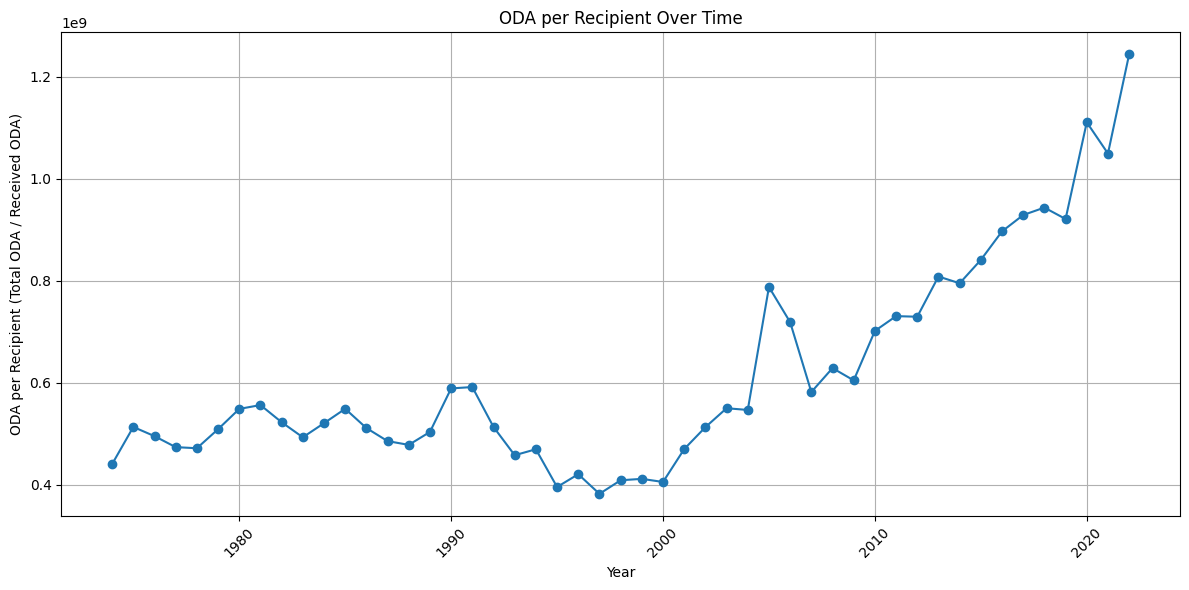

In [5]:
# Summarize ODA by year, first treatment, and received ODA
oda_summary = (
    merged_df.groupby("year")
    .agg({"oda": "sum", "first_treat": "sum", "received_oda_this_year": "sum"})
    .reset_index()
)

# Calculate ODA ratio
oda_summary["ODA Ratio"] = oda_summary["oda"] / oda_summary["received_oda_this_year"]

# Display summary
pd.set_option("display.float_format", "{:.2f}".format)
print(oda_summary.to_string(index=False))
pd.reset_option("display.float_format")

# Plot the ODA ratio
plt.figure(figsize=(12, 6))
plt.plot(oda_summary["year"], oda_summary["ODA Ratio"], marker="o")
plt.title("ODA per Recipient Over Time")
plt.xlabel("Year")
plt.ylabel("ODA per Recipient (Total ODA / Received ODA)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- It appears that most countries receiving ODA are "always treated," meaning they consistently receive aid throughout the period.
- The **ODA per recipient** has generally been increasing over time, especially after the 2000s. This

### Here, countries are classified into three groups—**Low ODA**, **Medium ODA**, and **High ODA**—based on the total amount of ODA they have received over the period.

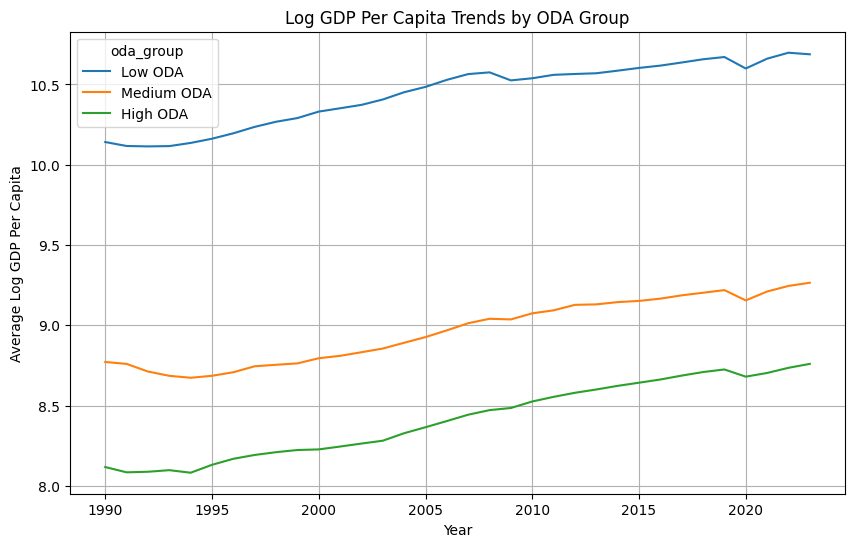

In [6]:
# Classify countries into three groups based on ODA quantiles
total_oda = merged_df.groupby("country_code")["oda"].sum()
oda_quantiles = total_oda.quantile([1 / 3, 2 / 3])
merged_df["oda_group"] = pd.cut(
    merged_df["country_code"].map(total_oda),
    bins=[-float("inf"), oda_quantiles.iloc[0], oda_quantiles.iloc[1], float("inf")],
    labels=["Low ODA", "Medium ODA", "High ODA"],
)

# Transform GDP per capita to its log and calculate average by year and ODA group
merged_df["log_gdp_per_capita"] = np.log(merged_df["gdp_per_capita"])
gdp_trends = (
    merged_df.groupby(["year", "oda_group"])["log_gdp_per_capita"].mean().reset_index()
)

# Plot the trends for each ODA group
plt.figure(figsize=(10, 6))
sns.lineplot(data=gdp_trends, x="year", y="log_gdp_per_capita", hue="oda_group")
plt.title("Log GDP Per Capita Trends by ODA Group")
plt.xlabel("Year")
plt.ylabel("Average Log GDP Per Capita")
plt.grid(True)
plt.show()


- Countries that receive more ODA (High ODA group) tend to have lower log GDP per capita values compared to those in the Low and Medium ODA groups.
- Despite this, the trends for all three ODA groups are **quite parallel**, indicating that while there are differences in the levels of GDP per capita, the rate of economic growth is relatively similar across all groups.

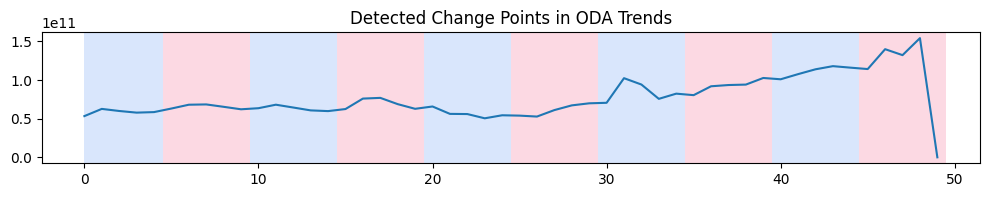

Change points in ODA detected at years:
1978
1983
1988
1993
1998
2003
2008
2013
2018
2023


In [7]:
# Extract the ODA time series for change point detection
oda_series = merged_df.groupby("year")["oda"].sum().values

# Apply the change point detection (with a specific model like 'l2')
algo = rpt.Pelt(model="l2").fit(oda_series)
change_points = algo.predict(
    pen=10
)  # Adjust the penalty to find more/fewer change points

# Plot the results with detected change points
rpt.display(oda_series, change_points)
plt.title("Detected Change Points in ODA Trends")
plt.show()

# Print the years where significant changes in ODA occurred
years = merged_df["year"].unique()
print("Change points in ODA detected at years:")
for cp in change_points:
    print(years[cp - 1])  # Adjust for 0-based indexing

These years correspond to periods when the slope of ODA trend shifted. 

Note: **2023** was initially detected as a change point, but it should be disregarded since there is no actual data available for that year in the dataset.


## 5. Corruption and ODA

In this section, I investigate the relationship between **Corruption Perception Index (CPI)** and ODA by dividing countries into two groups—**High Corruption** and **Low Corruption**—based on their 2014 CPI scores. The aim is to explore how ODA status compares between countries with high and low corruption levels.


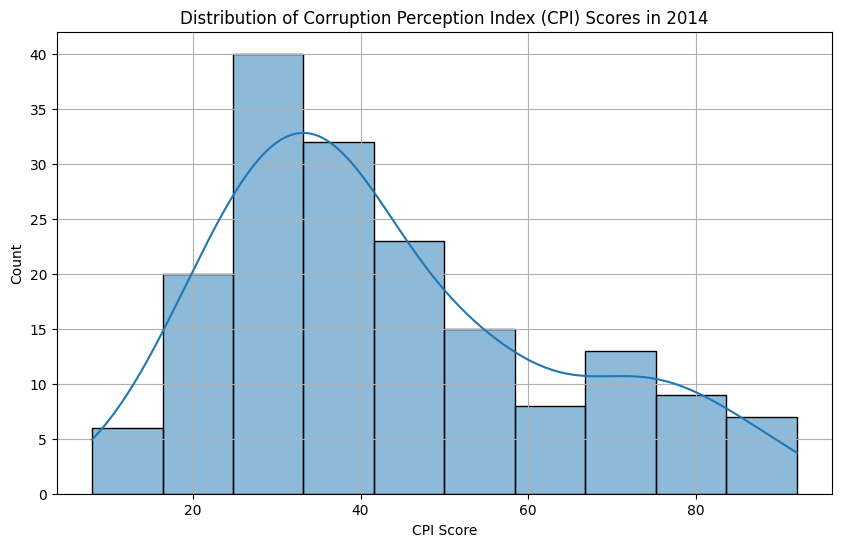

In [8]:
# Create groups based on ti_cpi_score values in 2014
df_2014 = merged_df[merged_df["year"] == 2014]

# Plot the distribution of ti_cpi_score
plt.figure(figsize=(10, 6))
sns.histplot(data=df_2014, x="ti_cpi_score", kde=True)
plt.title("Distribution of Corruption Perception Index (CPI) Scores in 2014")
plt.xlabel("CPI Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Calculate the median CPI score to split the groups
median_cpi = df_2014["ti_cpi_score"].median()

# Create a new column for corruption group
merged_df["corruption_group"] = merged_df.apply(
    lambda row: "High Corruption"
    if row["year"] == 2014 and row["ti_cpi_score"] < median_cpi
    else (
        "Low Corruption"
        if row["year"] == 2014 and row["ti_cpi_score"] >= median_cpi
        else None
    ),
    axis=1,
)

# Fill the corruption group for other years based on the 2014 classification
merged_df["corruption_group"] = (
    merged_df.groupby("country_code")["corruption_group"]
    .fillna(method="ffill")
    .fillna(method="bfill")
)


- The **peak of the distribution** is around a CPI score of 30-40, indicating that a significant number of countries have moderate to high levels of perceived corruption.
  
- Fewer countries have **higher CPI scores** (indicating lower corruption), with a gradual decline in frequency as the CPI score increases above 50. Very few countries have CPI scores above 80, signifying a small group of nations with very low corruption.


In [9]:
# Function to calculate percentages
def calculate_percentages(df):
    total = len(df)
    recipients = df["oda_recipient"].sum()
    non_recipients = total - recipients
    return recipients / total, non_recipients / total


# Calculate and print percentages for both corruption groups
for corruption_level in ["Low", "High"]:
    corruption_df = merged_df[
        merged_df["corruption_group"] == f"{corruption_level} Corruption"
    ]
    unique_corruption = corruption_df.drop_duplicates(subset=["country_code"])

    recipient_percentage, non_recipient_percentage = calculate_percentages(
        unique_corruption
    )

    print(f"\nFor {corruption_level} Corruption countries:")
    print(f"\tODA Recipients: {recipient_percentage:.4f}")
    print(f"\tNon-ODA Recipients: {non_recipient_percentage:.4f}")


For Low Corruption countries:
	ODA Recipients: 0.6526
	Non-ODA Recipients: 0.3474

For High Corruption countries:
	ODA Recipients: 0.9885
	Non-ODA Recipients: 0.0115


In [10]:
# Calculate change in CPI and classify corruption trend
merged_df["cpi_change"] = merged_df.groupby("country_code")["ti_cpi_score"].diff()
avg_cpi_change = merged_df.groupby("country_code")["cpi_change"].mean().reset_index()
threshold = avg_cpi_change["cpi_change"].median()
avg_cpi_change["corruption_trend"] = np.where(
    avg_cpi_change["cpi_change"] > threshold, "Improving", "Worsening"
)
merged_df = pd.merge(
    merged_df, avg_cpi_change[["country_code", "corruption_trend"]], on="country_code"
)

# Calculate and print percentages
total_countries = len(avg_cpi_change)
trend_counts = avg_cpi_change["corruption_trend"].value_counts()
for trend in ["Improving", "Worsening"]:
    count = trend_counts.get(trend, 0)
    print(
        f"Percentage of countries with {trend.lower()} corruption: {count/total_countries*100:.2f}%"
    )

# Analyze ODA recipients among improving countries
improving_countries = merged_df[
    merged_df["corruption_trend"] == "Improving"
].drop_duplicates(subset=["country_code"])
total_improving = len(improving_countries)
oda_recipients = improving_countries["oda_recipient"].sum()

print("\nAmong countries with improving corruption:")
print(f"ODA Recipients: {oda_recipients} ({oda_recipients/total_improving*100:.2f}%)")
print(
    f"Non-ODA Recipients: {total_improving-oda_recipients} ({(total_improving-oda_recipients)/total_improving*100:.2f}%)"
)


Percentage of countries with improving corruption: 46.15%
Percentage of countries with worsening corruption: 53.85%

Among countries with improving corruption:
ODA Recipients: 73 (86.90%)
Non-ODA Recipients: 11 (13.10%)


-  High corruption countries are overwhelmingly ODA recipients (98.85%), while low corruption countries are less likely to receive ODA (65.26%).

-  46.15% of countries show improving corruption, while 53.85% are worsening.


## 5. Data Preparation for Analysis

### Data Filtering and Choices:

Based on the historical analysis, and to ensure a more balanced and unbiased examination of ODA effectiveness, we take the following steps:

5.1. **Exclusion of Wealthier Countries**: 
   - By filtering out the wealthiest nations (top 33rd percentile), we ensure the analysis is focused on lower-income and developing countries where ODA has the most potential impact.


5.2. **Dummy Variables for Regions**:
   - These dummy variables will help capture any unobserved heterogeneity that might influence the relationship between ODA and economic performance across different parts of the world.





In [11]:
# Calculate the 67th percentile of log_gdp_per_capita (top 33rd percentile)
gdp_threshold = merged_df["log_gdp_per_capita"].quantile(0.67)
# Create a mock DataFrame to simulate the exclusion
exclusion_df = merged_df.copy()
# Get the excluded countries
excluded_countries = exclusion_df[exclusion_df["log_gdp_per_capita"] >= gdp_threshold][
    "country_name"
].unique()
# Print the excluded countries
print("\nExcluded Countries (Top 33rd Percentile of GDP per capita):")
for country in excluded_countries:
    print(f"- {country}")


Excluded Countries (Top 33rd Percentile of GDP per capita):
- Argentina
- Armenia
- Australia
- Austria
- Azerbaijan
- Bahamas, The
- Bahrain
- Belarus
- Belgium
- Brunei Darussalam
- Bulgaria
- Canada
- Chile
- China
- Costa Rica
- Croatia
- Cyprus
- Czechia
- Denmark
- Dominican Republic
- Equatorial Guinea
- Estonia
- Finland
- France
- Gabon
- Georgia
- Germany
- Greece
- Guyana
- Hong Kong SAR, China
- Hungary
- Iceland
- Ireland
- Israel
- Italy
- Japan
- Kazakhstan
- Korea, Rep.
- Kuwait
- Latvia
- Libya
- Lithuania
- Luxembourg
- Malaysia
- Maldives
- Malta
- Mauritius
- Mexico
- Montenegro
- Netherlands
- New Zealand
- North Macedonia
- Norway
- Oman
- Panama
- Poland
- Portugal
- Puerto Rico
- Qatar
- Romania
- Russian Federation
- Saudi Arabia
- Serbia
- Seychelles
- Singapore
- Slovak Republic
- Slovenia
- Spain
- St. Lucia
- Suriname
- Sweden
- Switzerland
- Thailand
- Trinidad and Tobago
- Turkiye
- Ukraine
- United Arab Emirates
- United Kingdom
- United States
- Urugua

In [ ]:
# Function to get region for a given country code
def get_region(country_code):
    try:
        return pc.convert_continent_code_to_continent_name(
            pc.country_alpha2_to_continent_code(
                pc.country_alpha3_to_country_alpha2(country_code)
            )
        )
    except:
        return "Unknown"


# Create a copy of the DataFrame to avoid SettingWithCopyWarning
filtered_df = merged_df.copy()

# Apply function to create 'region' column
filtered_df["region"] = filtered_df["country_code"].apply(get_region)

# Print countries with unknown region
unknown_region_countries = filtered_df[filtered_df["region"] == "Unknown"]
print("\nCountries with unknown region:")
unique_unknown = unknown_region_countries.drop_duplicates(
    subset=["country_name", "country_code"]
)
print(
    "\n".join(
        f"- {row['country_name']} ({row['country_code']})"
        for _, row in unique_unknown.iterrows()
    )
)

# Create dummy variables for specific regions and fill missing ODA
for region in ["Africa", "Asia", "South America"]:
    filtered_df.loc[:, f"is_{region.lower().replace(' ', '_')}"] = (
        filtered_df["region"] == region
    ).astype(int)



Countries with unknown region:
- Kosovo (XKX)
- Timor-Leste (TLS)



5.3. **Log Transformation of ODA**:
   - Since ODA is highly skewed, we apply a **log transformation** to better approximate a normal distribution.
   - A small constant (1) is added to ODA before taking the logarithm to handle cases where ODA is zero.

5.4. **Exclusion of Countries with Zero ODA**:
   - A small number of countries have **ODA equal to zero** at least once during the analysis period. After log transformation, these countries become outliers as zero.
   - To avoid skewing the results, we eliminate these countries from the dataset.

### Applying the filters

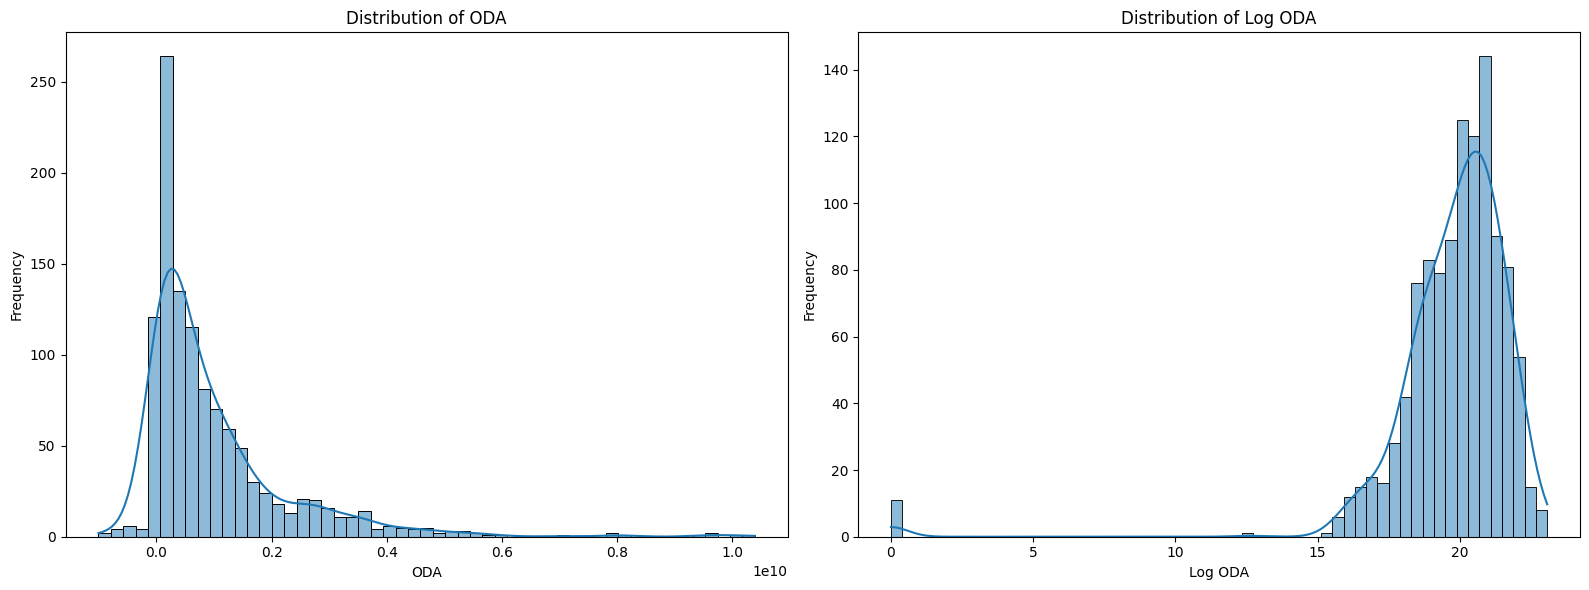

In [13]:
def filter_dataset(df):
    # Calculate the average log_gdp_per_capita for each country across all periods
    country_avg_gdp = df.groupby("country_code")["log_gdp_per_capita"].mean()

    # Calculate the 67th percentile of average log_gdp_per_capita
    gdp_threshold = country_avg_gdp.quantile(0.67)

    # Identify countries with average log_gdp_per_capita below the threshold
    countries_below_threshold = country_avg_gdp[country_avg_gdp < gdp_threshold].index

    # Filter the DataFrame
    df = df[df["country_code"].isin(countries_below_threshold)]
    df = df[~df["region"].isin(["Europe", "Oceania"])]
    df = df[(df["year"] >= 2012) & (df["year"] <= 2022)]

    # Define log_oda
    df["log_oda"] = np.log(df["oda"] + 1)

    return df


filtered_df = filter_dataset(filtered_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ODA distribution
sns.histplot(filtered_df["oda"], kde=True, ax=ax1)
ax1.set_title("Distribution of ODA")
ax1.set_xlabel("ODA")
ax1.set_ylabel("Frequency")

# Log ODA distribution
sns.histplot(filtered_df["log_oda"], kde=True, ax=ax2)
ax2.set_title("Distribution of Log ODA")
ax2.set_xlabel("Log ODA")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [14]:
# Drop countries with at least one value equal to 0 in the oda or log_oda series
countries_with_oda_zero = filtered_df[filtered_df["oda"] == 0]["country_code"].unique()
countries_with_log_oda_zero = filtered_df[filtered_df["log_oda"] == 0][
    "country_code"
].unique()
countries_to_drop = set(countries_with_oda_zero).union(set(countries_with_log_oda_zero))

filtered_df = filtered_df[~filtered_df["country_code"].isin(countries_to_drop)]


### 5.5a. Identifying Missing Values
To ensure the dataset is complete and suitable for analysis, we perform the following steps to identify and impute missing values:

   - We calculate the percentage of missing values for each column to understand the extent of missing data. 


In [15]:
# Calculate and display percentage of missing values for each column
missing_percentages = (filtered_df.isnull().sum() / len(filtered_df)) * 100
missing_table = pd.DataFrame(
    {
        "Column": missing_percentages.index,
        "Percentage Missing": missing_percentages.values,
    }
)
print("Percentage of Missing Values by Column:")
print(
    missing_table.sort_values("Percentage Missing", ascending=False).to_string(
        index=False
    )
)


Percentage of Missing Values by Column:
                Column  Percentage Missing
             education           56.951872
       gov_expenditure           13.725490
        trade_openness           13.368984
            cpi_change           10.962567
           ti_cpi_rank            3.297683
           fdi_inflows            1.782531
               log_oda            1.693405
         ti_cpi_stderr            1.426025
          ti_cpi_score            1.426025
        ti_cpi_sources            1.426025
      urban_population            0.980392
             inflation            0.267380
        gdp_per_capita            0.178253
    log_gdp_per_capita            0.178253
     population_growth            0.000000
      corruption_group            0.000000
      is_south_america            0.000000
               is_asia            0.000000
             is_africa            0.000000
                region            0.000000
      corruption_trend            0.000000
              

### 5.5b. Columns with less than 5% missing values are handled with simpler methods, while those with higher percentages are imputed using more advanced techniques.

 - **Linear Interpolation for Low Missingness**:
   - For columns with less than **5% missing data**, we apply **linear interpolation** based on neighboring years.

 - **KNN Imputation for Higher Missingness**:
   - For columns with **10-15% missing values**, we use **K-Nearest Neighbors (KNN) imputation**. This method leverages the similarity between countries to estimate missing values. Before applying KNN, the numeric columns are standardized to ensure proper distance calculations.

Columns with too many missing values are excluded from the analysis.

In [16]:
filtered_df = filtered_df.set_index(["country_code", "year"])


# Function to impute with linear interpolation based on nearest years
def impute_with_nearest_years(df, columns_to_impute):
    df_imputed = df.copy()

    for column in columns_to_impute:
        if column in df_imputed.columns and df_imputed[column].isnull().any():
            # Interpolate within each country based on time using transform
            df_imputed[column] = df_imputed.groupby("country_code")[column].transform(
                lambda x: x.interpolate(method="linear", limit_direction="both")
                .ffill()
                .bfill()
            )

    return df_imputed


# KNN imputation function
def impute_knn(df, columns_to_impute, n_neighbors=30):
    df_copy = df.copy()
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    df_copy[numeric_cols] = scaler.fit_transform(df_copy[numeric_cols])
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_copy[numeric_cols] = imputer.fit_transform(df_copy[numeric_cols])
    df_copy[numeric_cols] = scaler.inverse_transform(df_copy[numeric_cols])
    return df_copy


# Define columns to impute
missing_percentages = (filtered_df.isnull().sum() / len(filtered_df)) * 100
columns_to_impute_simple = missing_percentages[
    (missing_percentages > 0) & (missing_percentages < 5)
].index.tolist()
# Apply nearest year interpolation
filtered_df = impute_with_nearest_years(filtered_df, columns_to_impute_simple)
# Select columns for KNN imputation
columns_to_impute_knn = missing_percentages[
    (missing_percentages >= 10) & (missing_percentages < 15)
].index.tolist()

print("Columns to impute using KNN:")
print(columns_to_impute_knn)

# Apply KNN imputation
filtered_df_imputed = impute_knn(filtered_df, columns_to_impute_knn)

# Print imputed values for trade openness to check if the imputation worked
column = "trade_openness"
if column in columns_to_impute_knn:
    print(f"\nCountries with imputed values for {column}:")
    comparison_df = pd.DataFrame(
        {
            "Value": filtered_df_imputed[column],
            "Is_Imputed": filtered_df[column].isnull()
            & ~filtered_df_imputed[column].isnull(),
        }
    )
    countries_with_imputed = comparison_df.groupby("country_code")["Is_Imputed"].any()
    countries_to_print = countries_with_imputed[countries_with_imputed]
    for country in countries_to_print.index:
        country_data = comparison_df[
            comparison_df.index.get_level_values("country_code") == country
        ]
        print(f"\nCountry: {country}")
        print("All periods after imputation:")
        for idx, row in country_data.iterrows():
            year = idx[1] if isinstance(idx, tuple) else idx
            imputed_flag = (
                "Is_Imputed=True" if row["Is_Imputed"] else "Is_Imputed=False"
            )
            print(f"Year: {year}, Value: {row['Value']:.4f}, {imputed_flag}")


# Update filtered_df
filtered_df = filtered_df_imputed


Columns to impute using KNN:
['gov_expenditure', 'trade_openness', 'cpi_change']

Countries with imputed values for trade_openness:

Country: AFG
All periods after imputation:
Year: 2012, Value: 49.3260, Is_Imputed=True
Year: 2013, Value: 45.6022, Is_Imputed=True
Year: 2014, Value: 45.4172, Is_Imputed=True
Year: 2015, Value: 39.9797, Is_Imputed=True
Year: 2016, Value: 43.1292, Is_Imputed=True
Year: 2017, Value: 36.8082, Is_Imputed=True
Year: 2018, Value: 36.8852, Is_Imputed=True
Year: 2019, Value: 42.2183, Is_Imputed=True
Year: 2020, Value: 46.7099, Is_Imputed=False
Year: 2021, Value: 51.4117, Is_Imputed=False
Year: 2022, Value: 72.8855, Is_Imputed=False

Country: DJI
All periods after imputation:
Year: 2012, Value: 116.1667, Is_Imputed=True
Year: 2013, Value: 347.9965, Is_Imputed=False
Year: 2014, Value: 299.3679, Is_Imputed=False
Year: 2015, Value: 268.3635, Is_Imputed=False
Year: 2016, Value: 213.0720, Is_Imputed=False
Year: 2017, Value: 305.9680, Is_Imputed=False
Year: 2018, Value:

#### Overall, the imputed values appear reasonable. We can run the 5.5a cell to confirm that all missing values have been successfully filled.

## 5.6. Transformations

- **GDP per Capita (log_gdp_per_capita)**:
  - Log-transformed to handle skewness and make the effects interpretable as **percentage changes**. 

- **ODA (log_oda_centered)**:
  - Log-transformed to normalize the distribution and interpret ODA's impact in proportional terms. Centered for easier interpretation of interactions and reduce multicollinearity.

- **CPI (log_cpi_score, dlog_cpi_score)**:
  - Log-transformed to capture the relationship between **corruption** and economic outcomes in percentage terms. The **first difference (dlog_cpi_score)** captures year-to-year changes in corruption. 

- **Interaction Term (log_oda_dlog_cpi_centered_interaction)**:
  - Created to explore how the effectiveness of ODA depends on **changes in corruption** - whether ODA is more or less effective as corruption improves or worsens in a country.




In [17]:
def transform_variables(df):
    df = df.copy()

    # Basic transformations
    df["oda"] = df["oda"].fillna(0).clip(lower=0)
    df["log_gdp_per_capita"] = df["log_gdp_per_capita"].fillna(
        df["log_gdp_per_capita"].median()
    )

    df["log_cpi_score"] = np.log(df["ti_cpi_score"])
    df["log_cpi_score"] = df["log_cpi_score"].replace([np.inf, -np.inf], np.nan)

    # Difference transformations
    df["dlog_cpi_score"] = df.groupby("country_code")["log_cpi_score"].diff().fillna(0)

    # Centered variables
    df["cpi_score_centered"] = df["ti_cpi_score"] - df["ti_cpi_score"].mean()
    df["log_cpi_score_centered"] = df["log_cpi_score"] - df["log_cpi_score"].mean()
    df["log_oda_centered"] = df["log_oda"] - df["log_oda"].mean()
    df["dlog_cpi_score_centered"] = df["dlog_cpi_score"] - df["dlog_cpi_score"].mean()

    # Interaction terms
    # Create interaction terms between log_oda_centered and log_cpi_score_centered, cpi_score_centered
    df["log_oda_log_cpi_centered_interaction"] = (
        df["log_oda_centered"] * df["log_cpi_score_centered"]
    )
    df["log_oda_cpi_centered_interaction"] = (
        df["log_oda_centered"] * df["cpi_score_centered"]
    )
    df["log_oda_dlog_cpi_centered_interaction"] = (
        df["log_oda_centered"] * df["dlog_cpi_score_centered"]
    )

    return df


filtered_df = transform_variables(filtered_df)



## 6.1 Panel Data Analysis

We use a **Two-Way Fixed Effects (TWFE)** model to analyze the impact of ODA and corruption on **GDP per capita**. This model has: 

- **Entity Effects (Country Fixed Effects)**
- **Time Effects (Year Fixed Effects)**
  
The inclusion of the interaction terms (**ODA × changes in CPI**) helps us test whether ODA's effectiveness is moderated by changes in corruption.


### Controls:
These variables allow the model to account for economic, political, and regional factors affecting GDP per capita.

- **Inflation**: Controls for macroeconomic stability.
- **Life Expectancy**: A proxy for human development and long-term economic prospects.
- **Region Dummies (Africa, South America)**: Controls for region-specific effects that may influence economic growth.
- **Government Expenditure, Trade Openness, FDI Inflows, Urbanization, Population Growth**: Standard macroeconomic controls that influence GDP growth.





In [18]:
def run_panel_regression(exog_vars):
    """
    Run a PanelOLS regression with entity and time effects.

    Parameters:
    exog_vars (list): List of exogenous variables for the model.

    Returns:
    panel_results: Fitted PanelOLS model results.
    """
    # Prepare panel data (exog and endog)
    exog_data = sm.add_constant(
        filtered_df[exog_vars]
    )  # Add a constant for the regression
    endog_data = filtered_df["log_gdp_per_capita"]

    # PanelOLS with entity effects (country fixed effects) and time effects (year fixed effects)
    panel_model = PanelOLS(
        endog_data,  # Pass the dependent variable (log_gdp_per_capita) as the first argument
        exog_data,  # Exogenous variables (including the constant)
        entity_effects=True,
        time_effects=True,
        drop_absorbed=True,
    )

    # Fit the model
    panel_results = panel_model.fit(cov_type="clustered", cluster_entity=True)

    # Print summary of results
    print(panel_results.summary)

    return panel_results


# Define exogenous variables for the model
exog_vars = [
    "log_oda_centered",
    "dlog_cpi_score_centered",
    "log_oda_dlog_cpi_centered_interaction",
    "inflation",
    "life_expectancy",
    "is_africa",
    "is_south_america",
    "gov_expenditure",
    "trade_openness",
    "fdi_inflows",
    "urban_population",
    "population_growth",
]

# Run the panel regression
panel_results = run_panel_regression(exog_vars)


                          PanelOLS Estimation Summary                           
Dep. Variable:     log_gdp_per_capita   R-squared:                        0.1174
Estimator:                   PanelOLS   R-squared (Between):             -0.0317
No. Observations:                1122   R-squared (Within):               0.0480
Date:                Thu, Oct 24 2024   R-squared (Overall):             -0.0306
Time:                        21:03:33   Log-likelihood                    1135.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.296
Entities:                         102   P-value                           0.0000
Avg Obs:                       11.000   Distribution:                 F(10,1000)
Min Obs:                       11.000                                           
Max Obs:                       11.000   F-statistic (robust):             2.2920
                            

### Coefficient Interpretation

- **Constant (9.3504)**: The baseline log GDP per capita when all controls are 0, and the variables of interest are at their mean (implicity 0 when centered).
  
- **log_oda_centered (-0.0131, p = 0.2189 )**: The coefficient on ODA is negative but statistically significant. 

- **dlog_cpi_score_centered (-0.0946, p = 0.0550)**: The negative sign would seem to indicate that a decrease in corruption (as CPI increases) is associated with lower GDP per capita, though this relationship is not statistically significant.

- **log_oda_dlog_cpi_centered_interaction (0.0488, p = 0.1208)**: The interaction between ODA and changes in corruption is close to zero and statistically insignificant, indicating no clear evidence that ODA's impact varies with changes in corruption.


Note: We can also observe that PanelOLS abosrbed the regional dummies, since they do not vary over time within a country, they are perfectly collinear with the fixed effects.

## 6.2 Robustness Checks

#### We calculate the **Variance Inflation Factor (VIF)** for each exogenous variable to check for **multicollinearity** in the model. We chose 10 as an indicator of high multicollinearity.

In [19]:
def run_and_print_vif(exog_vars):
    """
    Calculate and print the Variance Inflation Factor (VIF) for the given exogenous variables.

    Parameters:
    exog_vars (list): List of exogenous variables for which to calculate VIF.
    """
    # VIF Calculation for the exogenous variables (ignoring fixed effects for now)
    X = filtered_df[exog_vars].copy()

    # Calculate VIF for each explanatory variable
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]

    # Print VIF results
    print("\nVariance Inflation Factor (VIF) Analysis:")
    print(vif_data)


run_and_print_vif(exog_vars)



Variance Inflation Factor (VIF) Analysis:
                                  Feature        VIF
0                        log_oda_centered   1.253786
1                 dlog_cpi_score_centered   1.045208
2   log_oda_dlog_cpi_centered_interaction   1.050172
3                               inflation   1.130142
4                         life_expectancy  17.101126
5                               is_africa   2.753101
6                        is_south_america   1.313208
7                         gov_expenditure   6.191112
8                          trade_openness   6.805931
9                             fdi_inflows   1.560103
10                       urban_population  10.136410
11                      population_growth   3.807672


In [20]:
# Define exogenous variables for the model
exog_vars_robust = [
    "log_oda_centered",
    "dlog_cpi_score_centered",
    "log_oda_dlog_cpi_centered_interaction",
    "inflation",
    "gov_expenditure",
    "trade_openness",
    "fdi_inflows",
    "urban_population",
    "population_growth",
]
panel_results_robust = run_panel_regression(exog_vars_robust)

run_and_print_vif(exog_vars_robust)

                          PanelOLS Estimation Summary                           
Dep. Variable:     log_gdp_per_capita   R-squared:                        0.1100
Estimator:                   PanelOLS   R-squared (Between):              0.0523
No. Observations:                1122   R-squared (Within):               0.0804
Date:                Thu, Oct 24 2024   R-squared (Overall):              0.0527
Time:                        21:03:33   Log-likelihood                    1130.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.753
Entities:                         102   P-value                           0.0000
Avg Obs:                       11.000   Distribution:                  F(9,1001)
Min Obs:                       11.000                                           
Max Obs:                       11.000   F-statistic (robust):             2.3613
                            

#### We can see that removing life_expectancy reduced multicollinearity for all variables under the threshold of 10.

#### Below I plot the  residuals vs. fitted values plot for an additional robustness check.

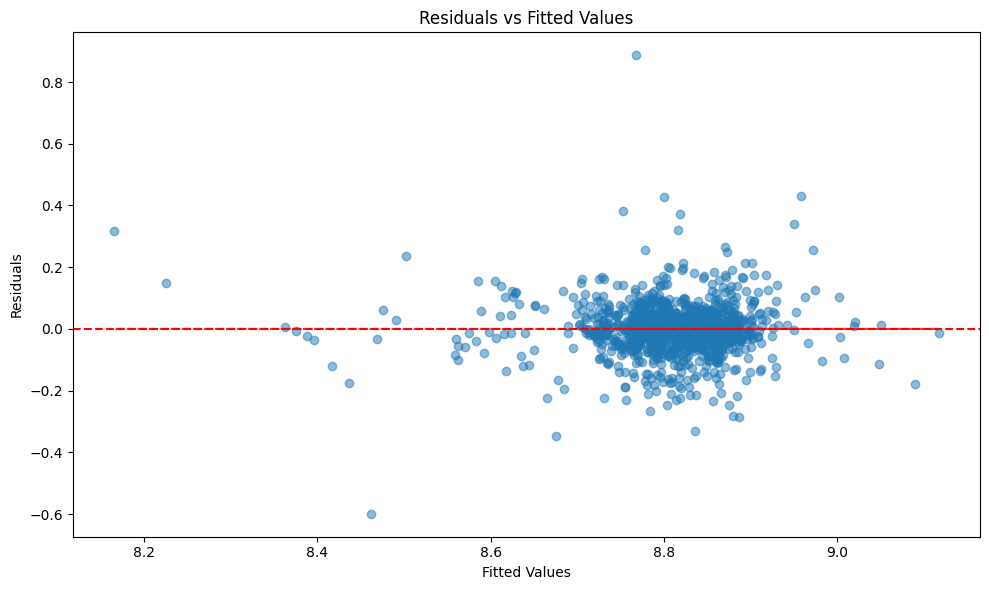

In [21]:
# Calculate residuals and fitted values
residuals = panel_results_robust.resids
fitted_values = panel_results_robust.fitted_values

# Convert to 1D arrays
residuals_1d = residuals.values.flatten()
fitted_values_1d = fitted_values.values.flatten()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values_1d, residuals_1d, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# Add a trend line
z = np.polyfit(fitted_values_1d, residuals_1d, 1)
p = np.poly1d(z)
plt.plot(fitted_values_1d, p(fitted_values_1d), "r--", alpha=0.8)

plt.tight_layout()
plt.show()


 - The residuals seem randomly scattered around zero, indicating that the model's predictions are generally unbiased.

 - The absence of a clear pattern suggests that the relationship between the dependent and independent variables is likely linear.

 - Some outliers are present, but they are not concentrated in any particular region of the plot.



#### The heatmap below visualizes the interaction effect between ODA (log_oda_centered) and changes in CPI (dlog_cpi_score_centered) on GDP per capita. The color gradient represents the predicted effect on GDP per capita, where:

- Red areas indicate positive effects on GDP per capita.
- Blue areas indicate negative effects on GDP per capita.

Of course, this heatmap would hold more relevance if the interaction term coeffient was statistically significant.

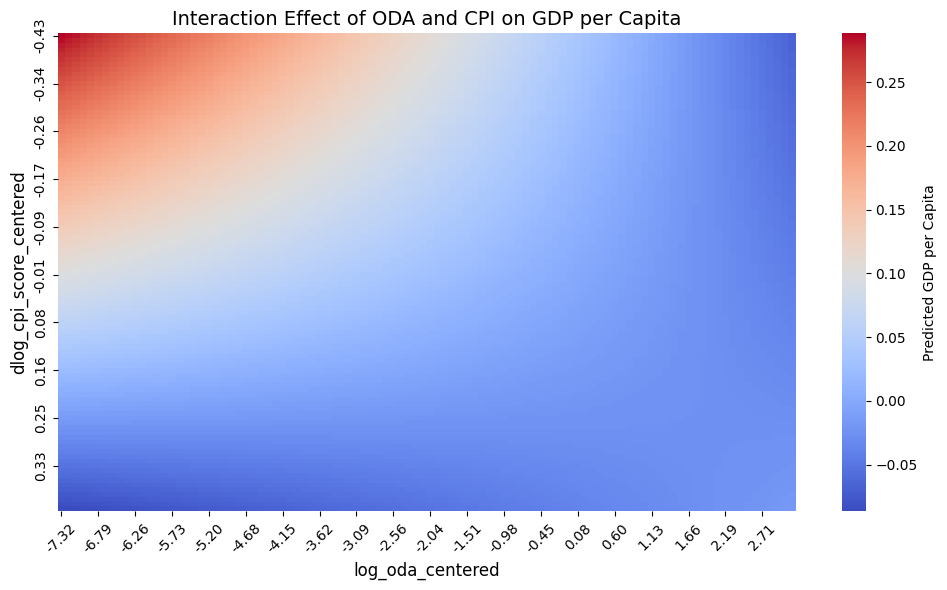

In [22]:
# Crte a range of values for the independent variables
oda_range = np.linspace(
    filtered_df["log_oda_centered"].min(), filtered_df["log_oda_centered"].max(), 100
)
cpi_range = np.linspace(
    filtered_df["dlog_cpi_score_centered"].min(),
    filtered_df["dlog_cpi_score_centered"].max(),
    100,
)

# Create meshgrid for ODA and CPI values
ODA, CPI = np.meshgrid(oda_range, cpi_range)

# Calculate the interaction term (log_oda * dlog_cpi)
interaction_term = ODA * CPI

# Use the coefficients from the model to calculate predicted GDP per capita
beta_oda = panel_results.params["log_oda_centered"]
beta_cpi = panel_results.params["dlog_cpi_score_centered"]
beta_interaction = panel_results.params["log_oda_dlog_cpi_centered_interaction"]

# Predict the dependent variable (GDP per capita) using the interaction model
predicted_gdp = beta_oda * ODA + beta_cpi * CPI + beta_interaction * interaction_term

# Plot the interaction effect
plt.figure(figsize=(10, 6))
sns.heatmap(
    predicted_gdp,
    cmap="coolwarm",
    xticklabels=5,
    yticklabels=10,  # Reduce number of ticks to avoid overlap
    cbar_kws={"label": "Predicted GDP per Capita"},
)

plt.title("Interaction Effect of ODA and CPI on GDP per Capita", fontsize=14)
plt.xlabel("log_oda_centered", fontsize=12)
plt.ylabel("dlog_cpi_score_centered", fontsize=12)

# Customize tick labels
xticks = plt.gca().get_xticks()
yticks = plt.gca().get_yticks()
plt.gca().set_xticklabels([f"{oda_range[int(x)]:.2f}" for x in xticks], rotation=45)
plt.gca().set_yticklabels([f"{cpi_range[int(y)]:.2f}" for y in yticks])

plt.tight_layout()
plt.show()


### Thank you for your consideration! 